# Double pendulum problem

A double pendulum is described in the configuration space by the equations:


In [1]:
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np
#Libraries for the rendering
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML

## Utilities

In [2]:
# Map to convert any angle to the range 0-2pi
def map_to_2pi(alpha):
  k = np.floor(alpha/(2*np.pi)) #Number of complete rotations
  alpha = alpha-k*2*np.pi
  return alpha

# Plot the pendulum
def plot_trajectory(data_frames, t_span=None, color='g'):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  #If the input is a single element make it a tuple, else, execute normally
  fig, ax = plt.subplots()
  max = []
  for df in data_frames:
    max.append(1.1*np.abs(df['y']).max()) #Find the maximum distance from the origin 
    
  fig.suptitle('Double pendulum')
      
  max = np.array(max).max() 
  
  ax.set_xlim(-max, max)
  ax.set_ylim(-max, max)
  ax.set_aspect('equal')
  ax.grid()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  if t_span != None:
    ax.text(0.05,0.9, f't = {t_span[1]:.2f}', transform = ax.transAxes)
  
  for df in data_frames:
    if t_span != None:
      df = df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])]
    
    ax.plot(df['x'], df['y'])
    ax.plot([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']], 'r-o')
  plt.show()

### A more complex function to animate using blitting

In [8]:
def create_plot(data_frames, color='g'):
  fig, ax = plt.subplots()
  max = []
  for df in data_frames:
    max.append(1.1*np.abs(df['y']).max()) #Find the maximum distance from the origin 
    
  fig.suptitle('Double pendulum')      
  max = np.array(max).max() 
  
  ax.set_xlim(-max, max)
  ax.set_ylim(-max, max)
  ax.set_aspect('equal')
  ax.grid(':')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  time = ax.text(0.05,0.9,'', transform = ax.transAxes)
  #NB: both traces and markers are memorized as an array of arrays containing the single element
  traces = [ax.plot(0,0, linestyle = '-', alpha=0.5) for df in data_frames]
  print(traces)
  markers = [ax.plot(0,0, c = trace[0].get_color(), linestyle = ':', marker = 'o') for trace in traces]
  plt.close('all')
  return fig, [traces, markers, time]

#Plots the figure by updating the objects inside
def plot_figure(data_frames, t_span=None):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  #If the input is a single element make it a tuple, else, execute normally
  fig, artists = create_plot(data_frames)
  traces, markers, time = artists[0], artists[1], artists[2]    
  
  # reduce the dataframes to the time limits 
  if t_span != None:  
    time.set_text(f't = {t_span[1]:.2f}')
    data_restricted = [df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])] for df in data_frames]
  else:
    data_restricted = data_frames

  #for all couples plot, df set the data of the plots
  for trace, df in zip(traces, data_restricted): trace[0].set_data(df['x'], df['y']) 
  for marker, df in zip(markers, data_restricted): marker[0].set_data([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']])   
  display(fig)

#Realtime animation 
def animate_RT(data_frames, time_step = 0.05, tail=2.5, t_stop=None):
  
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames) 
  fig, artists = create_plot(data_frames)
  if t_stop == None:
    t_stop = data_frames[0].iloc[-1]['t']
  t = 0
  
  while t<t_stop:
    update(t, tail, data_frames, artists)
    display(fig)
    clear_output(wait=True) 
    t = t + time_step
    
def update(t, tail, data_frames, artists, t_step=None):
  if t_step != None:
    t = t*t_step
  traces, markers, time = artists[0], artists[1], artists[2]   
  
  time.set_text(f't = {t:.2f}')
  data_restricted = [df[(df['t'] >= t-tail) & (df['t'] <= t)] for df in data_frames]
  
  for trace, df in zip(traces, data_restricted): trace[0].set_data(df['x'], df['y']) 
  for marker, df in zip(markers, data_restricted): marker[0].set_data([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']])   
    
def animate_HTML(data_frames, duration=5.0, tail = 2.5, fps=10):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames) 
  fig, artists = create_plot(data_frames)
  fps = 10
  t_step = duration*fps
  ani = animation.FuncAnimation(fig, update, round(duration*fps), fargs = (tail, data_frames, artists, t_step), interval = 1000.0/fps, blit=False)
  return ani

## Lagrangian of the pendulum

In [4]:
# dy/dt = f(t,y), with y = (theta, dtheta/dt)

def f(t, y, g, r):
  return(y[1], g/r*np.sin(y[0]))

g = 9.81
r = 0.5
m = 0.1

def pendulum_df(y0, t_span, m, g, r, n_points=1000):  
  
  Y = solve_ivp(f, t_span=t_span, y0=y0 , method='RK45', args=(g,r), t_eval=np.linspace(t_span[0],t_span[1], n_points), rtol=1e-6)
  pendulum_df = pd.DataFrame({'t':Y.t, 'theta': map_to_2pi(Y.y[0]), 'v_theta': Y.y[1]})
  pendulum_df['K'] = 0.5*m*(r*pendulum_df['v_theta'])**2
  pendulum_df['U'] = g*m*r*np.cos(pendulum_df['theta'])
  pendulum_df['E'] = pendulum_df['K']+ pendulum_df['U']

  pendulum_df['x'] = r*np.sin(pendulum_df['theta'])
  pendulum_df['y'] = r*np.cos(pendulum_df['theta'])
  return pendulum_df

a = pendulum_df(y0=(2.5, 0.0), t_span=(0,5.0), m=1, g=9.81, r=0.23)
b = pendulum_df(y0=(0.3,0.0), t_span=(0,5.0), m=1, g=9.81, r=0.1)

'''plot_trajectory(a, t_span=(0,0.3))
plt.plot(a['t'], a['theta'])
plt.plot(a['t'], a['v_theta'])
a.head(4)'''

"plot_trajectory(a, t_span=(0,0.3))\nplt.plot(a['t'], a['theta'])\nplt.plot(a['t'], a['v_theta'])\na.head(4)"

In [5]:
#plot_figure(a, t_span=(0,2.1))

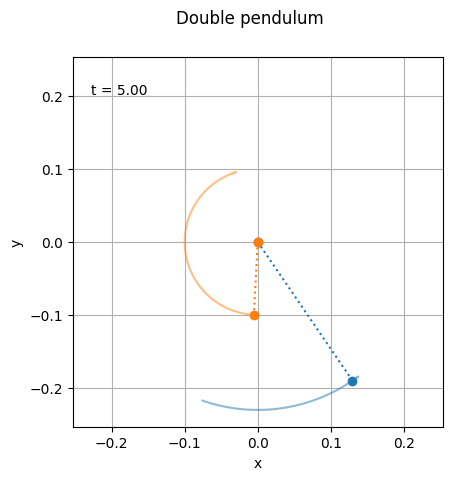

In [11]:
animate_RT((a,b), tail=0.4)

In [9]:
ani = animate_HTML((a,b), duration=5.0, tail=2.5)
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

[[<matplotlib.lines.Line2D object at 0x7fbc28f62a10>], [<matplotlib.lines.Line2D object at 0x7fbc2961ffa0>]]


IndexError: single positional indexer is out-of-bounds